# New York Taxi Fare Prediction Notebook

This notebook has been created as a basic entry into the [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview) competition on Kaggle. This is a good starting notebook which will go through data cleaning and visualisation, feature selection, hyperparameter tuning and finally training a model to generate predictions for submission to the competition. I wrote a post that goes through this notebook in detail which can be [found here.](https://www.apmarkham.com/posts/nyc-taxi-kaggle/)

## Part 1 - Data Cleaning and Feature Selection

In [1]:
# Import the packages that we will be using
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

After importing the required packages we import the train and test data. Note that we aren't loading the entire train data here - only 2 million rows. The entire data file contains over 54 million rows and loading all this would take a significant amount of time to clean, visualise and train. However with a powerful system you could load more data, just keep in mind the extra time this will take to run.

I have published this notebook using a Kaggle kernel with just 2 million rows of train data loaded, but have also trained this model using the full data on my local system and saw some improvement in my final score, so if possible, run this in an environment where you can take advantage of the full data.

In [2]:
# Load in our train and test data
train = pd.read_csv("data/input/train.csv", nrows=2000000)  # 2 million rows loaded initially
test = pd.read_csv("data/input/test.csv")

Let's inspect the shape of the data and take a look at the columns in each set.

In [3]:
print("Data loaded.")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print('Train columns: ', train.columns.tolist())
print('Test columns:  ', test.columns.tolist())

# Let's take a quick initial look at an overview of our train data
train.describe()

Data loaded.
Train shape: (2000000, 8)
Test shape: (9914, 7)
Train columns:  ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
Test columns:   ['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


We can see that the fare_amount is what we're looking to predict using our test data.

We will begin by looking at cleaning this data. First we remove any rows in the train data that have missing data. Next, if the fare amount is zero, or the amount of passengers in the taxi is zero, it doesn't make much sense, so lets drop those observations as well.

We will also constrain the passenger count - looking at our summary statistics above we can see the maximum passenger count is 208, which isn't very realistic for a taxi. We will constrain the passenger count to a maximum of 6 passengers. We have 54 million total observations (with 2m loaded), so dropping any observations that don't make sense isn't a problem.

In [4]:
# Perform cleaning here, drop NaN rows (rows with empty cells)
train.dropna(inplace=True)

# Drop the <=0 fares from the dataset, keeping only fares >0
train = train[train["fare_amount"] > 0]

# Now we want to look at the passenger count. If there is zero passengers, drop the observation
train = train[train["passenger_count"] > 0]
# If there is more than 6 passengers, also drop the observation
train = train[train["passenger_count"] <= 6]

The next thing to think about is the location data. Looking at the columns above, we know that we have the pickup and dropoff latitude and longitude for each observation. However the maximum and minimum values in our summary statistics table above reveals a lot of inaccuracy. We know that this dataset focuses on NYC, so we should be dropping records where either the onboard GPS has potentially failed and is returning values at null island (0, 0) or values that are incorrect (i.e. in the ocean/outside of NY state).

Let us first visualise the pickup and dropoff locations on a map of the world. It is important to note that using Geopandas and shapefiles is certainly not the most efficient way to visualise this - normal plots are faster but provide less detail. Finding a balance between these two can be difficult and a good exercise for the learner is to try visualise this in a different way!

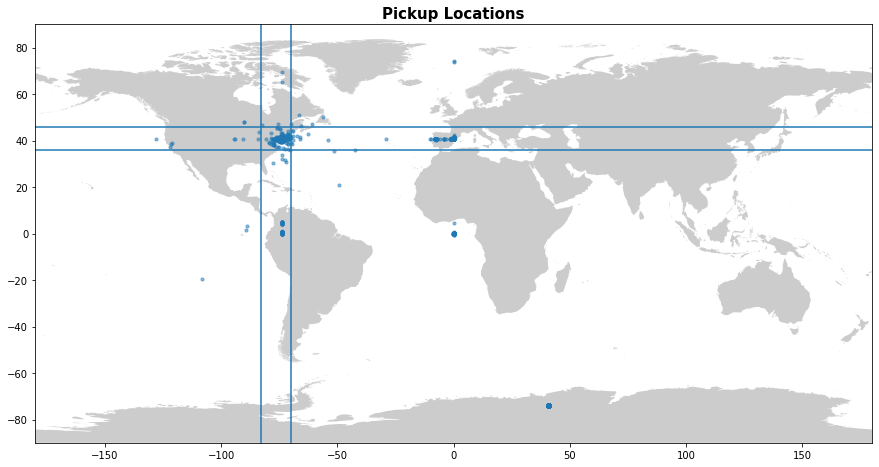

In [5]:
street_map = gpd.read_file("shapefiles/worldmap/WB_Land_10m.shp")

# Create a dataframe using Geopandas to hold the pickup longitude and latitude values from the train dataset
geo_df = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(x=train["pickup_longitude"], y=train["pickup_latitude"]))

# Now we create our figure and axes and assign these to out plot
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, alpha=0.5, legend=True, markersize=10)

# Give our plot a title
plt.title("Pickup Locations", fontsize=15, fontweight="bold")

# Set latitude and longitude boundaries for the large overview of the world map
plt.xlim(-180, 180)
plt.ylim(-90, 90)

# These lines very roughly represent where our cutoff point should be for NY state
plt.axvline(x=-70)
plt.axvline(x=-83)
plt.axhline(y=36)
plt.axhline(y=46)

plt.show()

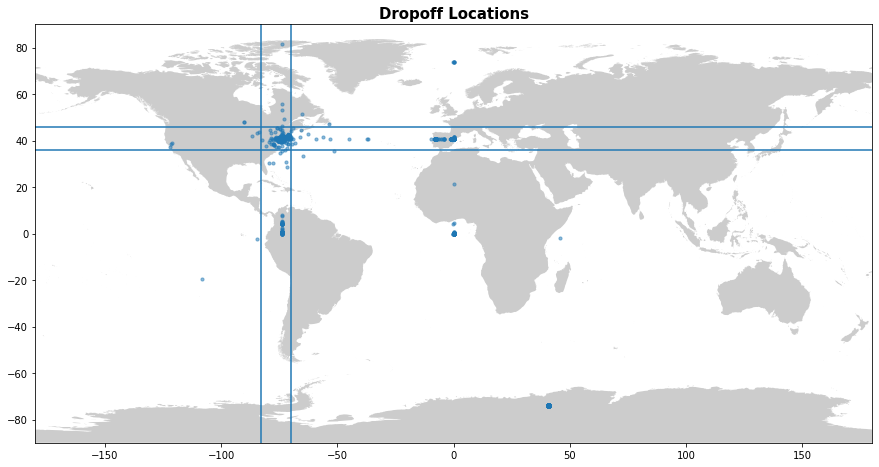

In [6]:
# Create a dataframe using Geopandas to hold the dropoff longitude and latitude values from the train dataset
geo_df = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(x=train["dropoff_longitude"], y=train["dropoff_latitude"]))

# Now we create our figure and axes and assign these to out plot
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, alpha=0.5, legend=True, markersize=10)

# Give our plot a title
plt.title("Dropoff Locations", fontsize=15, fontweight="bold")

# Set latitude and longitude boundaries for the large overview of the world map
plt.xlim(-180, 180)
plt.ylim(-90, 90)

# These lines very roughly represent where our cutoff point should be for NY state
plt.axvline(x=-70)
plt.axvline(x=-83)
plt.axhline(y=36)
plt.axhline(y=46)

plt.show()

Now we can see our outliers visually for both the pickup and dropoff locations. They are scattered all over the globe, with points at null island (0, 0), as well as in Europe, South America, and even Antarctica! Let's get rid of these outliers, constraining the trips to those within NY.

As a side note, both these plots could be merged into one, but the overlap makes it hard to see some outliers and to identify whether they are pickup or dropoff outliers. It's far better to have two seperate plots to look at.

It's also worth noting that the longitude/latitude chop below is a rough one. There are ways to do this accurately but we will not go into this in an introductory submission.

In [7]:
# Drop any records that have zero longitude/latitude, or long/lats that are outside bounds. Rembmer our longitude for NYC is always negative.
# This is going to be a rough chop, there is a significant amount of outliers to discuss
train = train[(train["pickup_longitude"] < -70) & (train["pickup_longitude"] > -83)]
train = train[(train["pickup_latitude"] > 36) & (train["pickup_latitude"] < 46 )]
train = train[(train["dropoff_longitude"] < -70) & (train["dropoff_longitude"] > -83)]
train = train[(train["dropoff_latitude"] > 36) & (train["dropoff_latitude"] < 46 )]

In [8]:
# Confirm that all our longitude and latitude values now fall within acceptable bounds
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.951822e+06,1.951822e+06,1.951822e+06,1.951822e+06,1.951822e+06,1.951822e+06
mean,1.134173e+01,-7.397527e+01,4.075090e+01,-7.397436e+01,4.075125e+01,1.690184e+00
std,9.748954e+00,4.504034e-02,3.453809e-02,4.407640e-02,3.745159e-02,1.305066e+00
min,1.000000e-02,-8.061666e+01,3.643386e+01,-8.264176e+01,3.723783e+01,1.000000e+00
25%,6.000000e+00,-7.399229e+01,4.073652e+01,-7.399160e+01,4.073550e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075333e+01,-7.398062e+01,4.075382e+01,1.000000e+00
75%,1.250000e+01,-7.396834e+01,4.076752e+01,-7.396536e+01,4.076839e+01,2.000000e+00
max,5.000000e+02,-7.000039e+01,4.534191e+01,-7.000226e+01,4.534191e+01,6.000000e+00


In [9]:
# See the new shape of our data after dropping the outlier coordinates
print("Train data shape: ", train.shape)

Train data shape:  (1951822, 9)


We have now dropped outliers from our dataset and we can see from the initial 2 million observations that we loaded from the train data, we now have 1.95 million. This means we've dropped around 50,000 observations or only 2.5% of our total - not bad at all.

Before we move on let's confirm that we've actually dropped all NaN values from the train dataset.

In [10]:
# Finally, search the train dataframe for any NaN values to confirm they have all been dropped successfully
print("NaN values:")
print(format(train.isna().sum()))

NaN values:
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
geometry             0
dtype: int64


Great, all the NaN values are gone.

The best way to confirm that the latitude and longitude data has been cleaned is visually, with a plot. First, we will use the same shapefile as before, the world map, comparing the before and after images.

Next we plot the latitude and longitude for pickup location on a shapefile map of the east coast of the United States. A third map is also provided, a map of NYC itself. The east coast map is useful for looking at outliers, while the NYC map is less useful but enjoyable to look at.

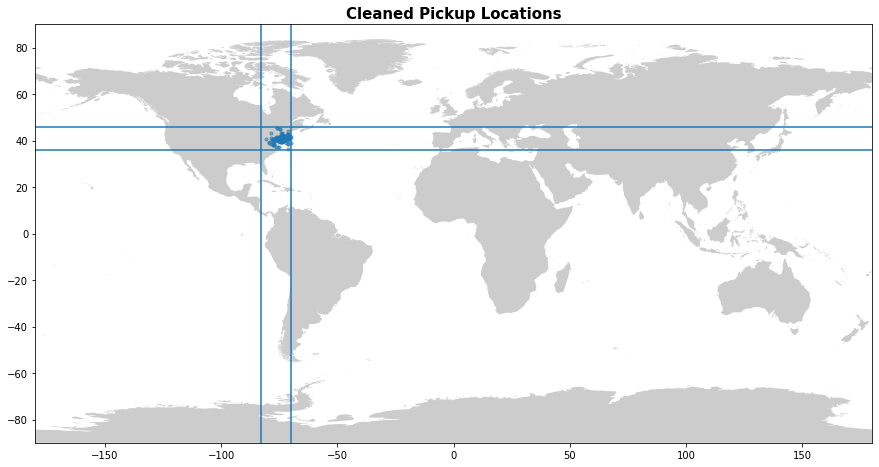

In [11]:
# Let us now visualise pickup and dropoff coordinates on two seperate maps so we can confirm that there are no outliers in our coordinates
geo_df = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(x=train["pickup_longitude"], y=train["pickup_latitude"]))

fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, alpha=0.5, legend=True, markersize=10)

plt.title("Cleaned Pickup Locations", fontsize=15, fontweight="bold")

# Set latitude and longitude boundaries
plt.xlim(-180, 180)
plt.ylim(-90, 90)

plt.axvline(x=-70)
plt.axvline(x=-83)
plt.axhline(y=36)
plt.axhline(y=46)

plt.show()

In [ ]:
geo_df = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(x=train["dropoff_longitude"], y=train["dropoff_latitude"]))

fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, alpha=0.5, legend=True, markersize=10)

plt.title("Cleaned Dropoff Locations", fontsize=15, fontweight="bold")

# Set latitude and longitude boundaries
plt.xlim(-180, 180)
plt.ylim(-90, 90)

plt.axvline(x=-70)
plt.axvline(x=-83)
plt.axhline(y=36)
plt.axhline(y=46)

plt.show()

Let's also look at a quick map of the east coast of the United States.

In [ ]:
street_map = gpd.read_file("shapefiles/eastus/ne_110m_land.shp")

# Create a dataframe using Geopandas to hold the pickup longitude and latitude values from the train dataset
geo_df = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(x=train["pickup_longitude"], y=train["pickup_latitude"]))

# Now we create our figure and axes and assign these to out plot
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, alpha=0.5, legend=True, markersize=10)

# Give our plot a title
plt.title("Pickup Locations - East Coast Map", fontsize=15, fontweight="bold")

# Set latitude and longitude boundaries for the large overview of the world map
plt.xlim(-90, -50)
plt.ylim(20.496103, 55.01585)

# These lines very roughly represent where our cutoff point should be for NY state
plt.axvline(x=-70)
plt.axvline(x=-83)
plt.axhline(y=36)
plt.axhline(y=46)

plt.show()

In [ ]:
street_map = gpd.read_file("shapefiles/nycity/geo_export_21a50042-3764-4df5-b711-bf69e0736421.shp")

# Now we create our figure and axes and assign these to out plot
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, alpha=0.5, legend=True, markersize=10)

# Give our plot a title
plt.title("Pickup Locations - NYC Map", fontsize=15, fontweight="bold")

# Set latitude and longitude boundaries for the 
plt.xlim(-74.02, -73.925)
plt.ylim(40.7, 40.8)

plt.show()

Great, we can see the vast majority of the points now lie within NY, on land. Now our mapping is complete, we can look at introducing new features into our dataset.

Again, it's important to think about a dataset like taxi fares from a logical point of view. For example, what sort of information would impact the fare of a taxi? The distance of the trip of course, but what else? The time of day? The day of the week? All these are features that could prove useful in our model, so let's introduce some of them into our dataset.

We will create 6 new features in total from our datetime object - the day of the week, the day of the month, the hour, the week of the year, the month, and the year.

In [ ]:
# Convert pickup date to datetime object
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
print("Datetime object created.")

# Create an hour feature
train['hour'] = train['pickup_datetime'].dt.hour
test['hour'] = test['pickup_datetime'].dt.hour
print("Hour created.")

# Create a day of week feature, map days from 0 to 6
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
print("DayOfWeek column created.")

# Create a day of the month feature
train['dayofmonth'] = train.pickup_datetime.dt.day
test['dayofmonth'] = test.pickup_datetime.dt.day

# Create a week of the year feature
train['week'] = train.pickup_datetime.dt.week
test['week'] = test.pickup_datetime.dt.week

# Create a month feature
train['month'] = train.pickup_datetime.dt.month
test['month'] = test.pickup_datetime.dt.month

# Create a year feature
train['year'] = train.pickup_datetime.dt.year
test['year'] = test.pickup_datetime.dt.year

Great, we've created six new features based on our datetime object. Now that we have added features based on the datetime column, we can look at using the latitude and longitude columns to add new features.

The first and most obvious one we will add is the distance of the trip in kilometres. This is done by using the Haversine distance formula to take in our latitude and longitude values, translating those into a distance in kilometers. First we define the function, and then apply this function to both the train and test data.

In [ ]:
# Define the Haversine distance formula to calculate the distance between two points on the Earth
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371  # Radius of the earth in km
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

# Calculate the ride distance and add it as a feature to our train and test sets
train['distance_km'] = haversine_distance(train["pickup_latitude"], train["pickup_longitude"], train["dropoff_latitude"], train["dropoff_longitude"])
test['distance_km'] = haversine_distance(test["pickup_latitude"], test["pickup_longitude"], test["dropoff_latitude"], test["dropoff_longitude"])

Now we've added the distance from point A to point B of the trip. However something that we can notice on our map plots above is that a lot of trips both originate and terminate at the three major airports in NY - JFK, EWR, and LGA. Often these trips will have a flat fee, and so adding features for these trips may help our model. Let's add one feature for pickup and one feature for dropoff, for each of the three major commercial airports in NY.

First we define the coordinates of the airports and then apply our haversine distance function that we used before to again calculate the airport distance.

In [ ]:
def from_airport_distance(dataset):

    # Define the coordinates for each airport
    jfk_coords = (40.639722, -73.778889)
    ewr_coords = (40.6925, -74.168611)
    lga_coords = (40.77725, -73.872611)

    dataset['pickup_jfk_distance'] = haversine_distance(jfk_coords[0], jfk_coords[1], dataset.pickup_latitude, dataset.pickup_longitude)
    dataset['dropof_jfk_distance'] = haversine_distance(jfk_coords[0], jfk_coords[1], dataset.dropoff_latitude, dataset.dropoff_longitude)
    
    dataset['pickup_ewr_distance'] = haversine_distance(ewr_coords[0], ewr_coords[1], dataset.pickup_latitude, dataset.pickup_longitude)
    dataset['dropof_ewr_distance'] = haversine_distance(ewr_coords[0], ewr_coords[1], dataset.dropoff_latitude, dataset.dropoff_longitude)
    
    dataset['pickup_lga_distance'] = haversine_distance(lga_coords[0], lga_coords[1], dataset.pickup_latitude, dataset.pickup_longitude)
    dataset['dropof_lga_distance'] = haversine_distance(lga_coords[0], lga_coords[1], dataset.dropoff_latitude, dataset.dropoff_longitude)
    
    return dataset

train = from_airport_distance(train)
test = from_airport_distance(test)

Another feature we can modify relates to our pickup and dropoff latitude and longitude coordinates. We won't actually be creating a new feature here, just converting the degrees to radians for the pickup and dropoff longitude and latitude values. Why do we do this? There's a great article [here](https://towardsdatascience.com/machine-learning-tip-using-rotational-data-b67ded0a33ad) explaining why, the summary is that radians make far more sense than degrees for a model to interpret.

In [ ]:
def degrees_to_radians(degree):
    return  np.radians(degree)    

train['pickup_latitude'] = degrees_to_radians(train['pickup_latitude'])
train['pickup_longitude'] = degrees_to_radians(train['pickup_longitude'])
train['dropoff_latitude'] = degrees_to_radians(train['dropoff_latitude'])
train['dropoff_longitude'] = degrees_to_radians(train['dropoff_longitude'])

test['pickup_latitude'] = degrees_to_radians(test['pickup_latitude'])
test['pickup_longitude'] = degrees_to_radians(test['pickup_longitude'])
test['dropoff_latitude'] = degrees_to_radians(test['dropoff_latitude'])
test['dropoff_longitude'] = degrees_to_radians(test['dropoff_longitude'])

Perfect. We've now added a number of new features. It's worth noting that this is only some of the features that can be added - there are many more that you could add!

Now let's try visualise our new features as well as the original features in the data. As we said previously, we expect the fare amount to change based on these new features. Remember that we have only loaded 2m rows of data for these visualisations - loading the entire dataset will give us a better look at what's going on!

First, let's take a look at the distance of our trip and see how the fare amount varies with increasing distance.

In [ ]:
# How does the distance affect the fare price?
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x="fare_amount", y="distance_km", marker=".", alpha=0.6)
plt.xlabel('Fare amount')
plt.ylabel('Distance, km')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.title('Fare amount based on the distance')
plt.show()

This plot is very interesting. We can see a very high concentration of trips between 0 and 40km in distance, and the fare for these trips seems to follow a relatively linear relationship - as the distance increases, so does the fare. However, this isn't the case for every trip visualised on this plot.

Something that could potentially improve this model is dropping trips above a certain distance. A trip above even 100km in a taxi would be incredibly rare in practice, and the fares certainly don't make a lot of sense for these trips. As an example, on this plot, at the 150km distance, most of these trips cost less than $50! This isn't realistic and really fails a logical check, so we could potentially improve our model by dropping these odd trips from our train data.

Next let's look at the passenger count and how it affects the price, as well as the distribution of the passenger count in each trip.

In [ ]:
# How does the passenger count affect the fare price?
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x="passenger_count", y="fare_amount", s=10)
plt.xlabel('Number of Passengers')
plt.ylabel('Fare')
plt.show()

# How many passengers are in each trip?
plt.figure(figsize=(12, 8))
sns.countplot(data=train, x="passenger_count", color=(89/255, 117/255, 164/255, 1))
plt.xlabel('Number of Passengers')
plt.ylabel('Observations')
plt.yticks([200000, 400000, 600000, 800000, 1000000, 1200000, 1400000], ["0.2M", "0.4M", "0.6M", "0.8M", "1M", "1.2M", "1.4M"])
plt.show()

We can see there isn't a significant relationship between passenger count and price. This is further apparent when we look at the distribution of passengers across all trips - the vast majority of trips have only one passenger on board.

We will now look at the hour of each trip and how this affects the fare price.

In [ ]:
# How does the hour affect the fare price?
hour_price = train.groupby('hour', as_index=False)['fare_amount'].median()

# Generate a line plot of the median fare for each hour
plt.figure(figsize=(12, 8))
sns.lineplot(data=hour_price, x="hour", y="fare_amount", marker="o")
plt.xlabel('Hour of the day')
plt.ylabel('Median fare amount')
plt.title('Fare amount based on day time')
plt.xticks(range(24))
plt.show()

# Let's also look at amount of trips by hour
plt.figure(figsize=(12, 8))
sns.countplot(data=train, x="hour", color=(89/255, 117/255, 164/255, 1))
plt.xlabel('Hour')
plt.ylabel('Observations')
plt.show()

We can see the highest median fare price comes in at 4am, and this makes a lot of sense. At such an early hour there is unlikely to be many customers looking for a taxi, and as such fares are increased. As we move into peak hours and during the day, the median fare price drops dramatically. It is between the hours of 10pm and 5am that the median fare price is higher.

This assumption is supported by our bar plot as well. The amount of trips is at a minimum at 5am, and starts to drop off at around 10pm. Less trips in the evening and early hours of the morning, leading to higher fares during those hours. Interesting to note is that the busiest hour is 7pm, likely a combination of some people returning home from work, and others on their way out for dinner.

We'll now look at the day of the week and how this affects the fare price, as well as the number of trips per day.

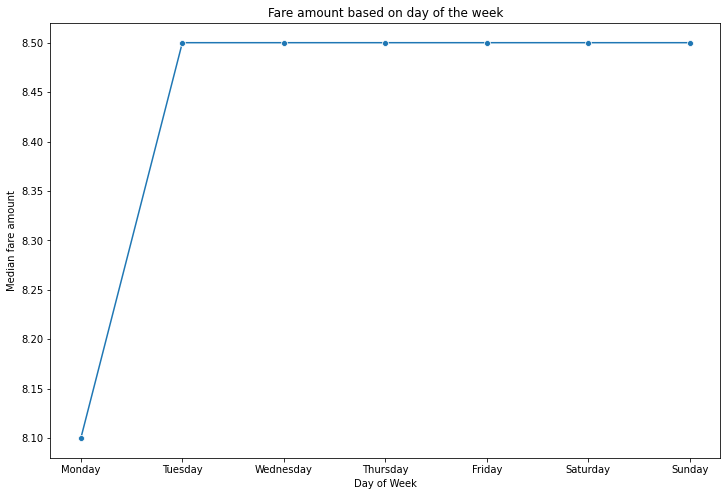

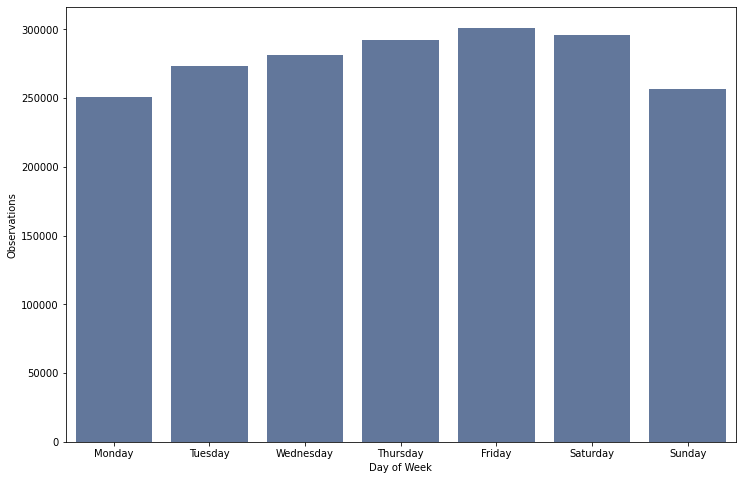

In [22]:
# How does the day of the week affect the fare price?
# Note that Monday is 0 and Sunday is 6 before labels are changed
day_price = train.groupby('dayofweek', as_index=False)['fare_amount'].median()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(12, 8))
sns.lineplot(data=day_price, x="dayofweek", y="fare_amount", marker="o")
plt.xlabel('Day of Week')
plt.ylabel('Median fare amount')
plt.title('Fare amount based on day of the week')
plt.xticks([0, 1, 2, 3, 4, 5, 6], days)
plt.show()

# How many trips are in each day?
plt.figure(figsize=(12, 8))
sns.countplot(data=train, x="dayofweek", color=(89/255, 117/255, 164/255, 1))
plt.xlabel('Day of Week')
plt.ylabel('Observations')
plt.xticks([0, 1, 2, 3, 4, 5, 6], days)
plt.show()

It's interesting to see that there isn't much of a relationship here. The fare amount remains constant except on a Monday, where the median fare is 40 cents lower than the rest of the days. The distribution of trips per day of the week doesn't show any significant variation either - Monday has the lowest amount of trips, but not by a significant margin. Friday has the most trips which makes some sense, a combination of people still going to and from work (unlike on weekends), but also has the added spike of trips for people going out for dinner on the Friday evening.

We can now look at the week of the year and see how this might affect our fare price.

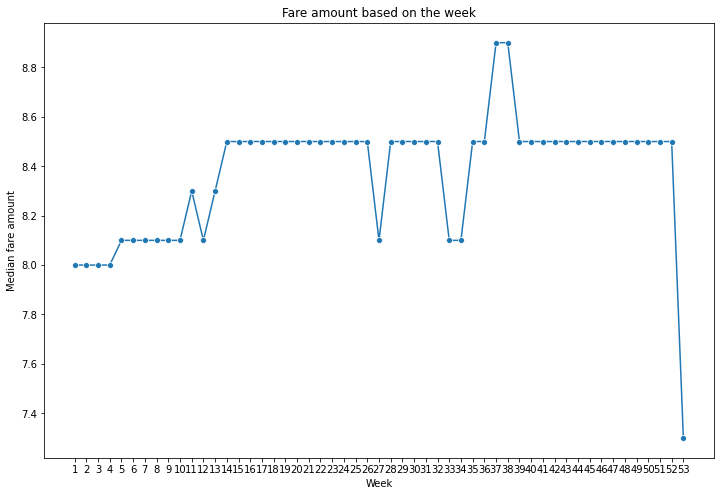

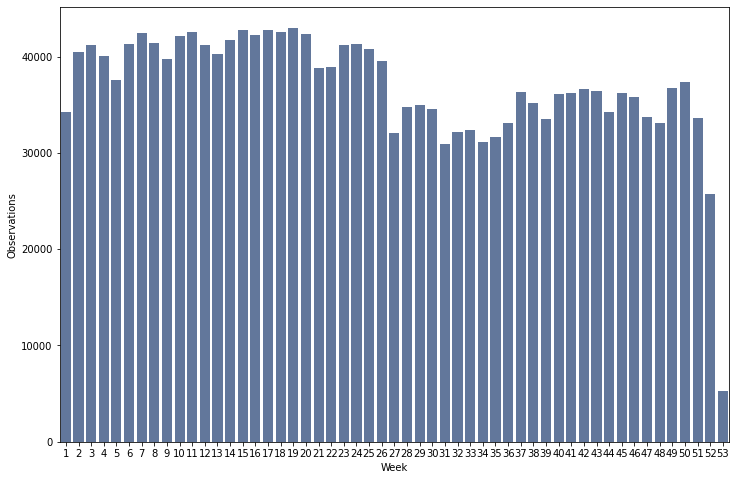

In [23]:
# How does the week of the year affect the price?
week_price = train.groupby('week', as_index=False)['fare_amount'].median()

plt.figure(figsize=(12, 8))
sns.lineplot(data=week_price, x="week", y="fare_amount", marker="o")
plt.xlabel('Week')
plt.ylabel('Median fare amount')
plt.xticks(range(1, 54))
plt.title('Fare amount based on the week')
plt.show()

# What is the frequency of trips in each week of the year?
plt.figure(figsize=(12, 8))
sns.countplot(data=train, x="week", color=(89/255, 117/255, 164/255, 1))
plt.xlabel('Week')
plt.ylabel('Observations')
plt.show()

The first thing you might notice here is that there's 53 weeks on these figures! This is because the year 2012 was a year with 53 weeks, a phenomenon that occurs every 5-6 years. Our data includes the years 2009-2015.

It is interesting to note that the number of trips is significantly higher in the first 26 weeks of the year, at which point we see a significant decline in week 27, and then a steady trend for the remainder of the year. The number of trips also drops off significantly in the final weeks of the year (51 and 52), likely due to Christmas and New Year celebrations. There isn't any other significant variation in the number of trips per week except in week 53, as there is only one week 53 in our data of 2009-2015.

We will now look at how the fare price changes through the months of the year.

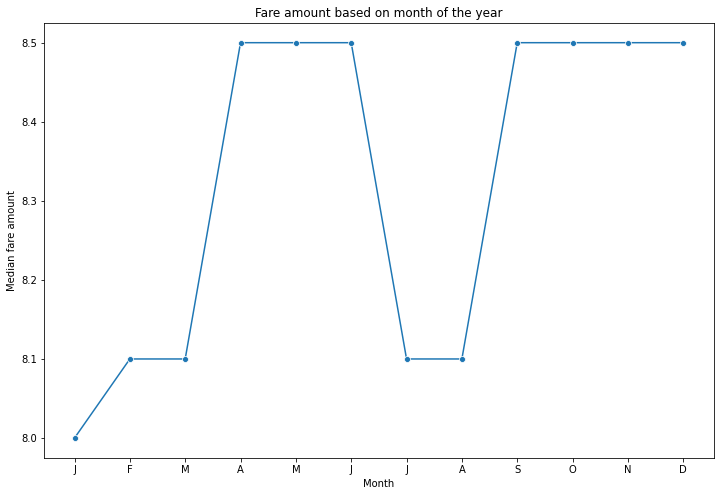

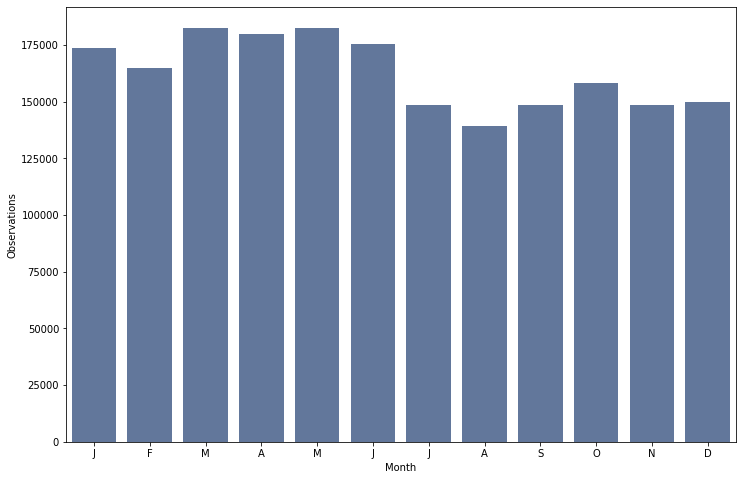

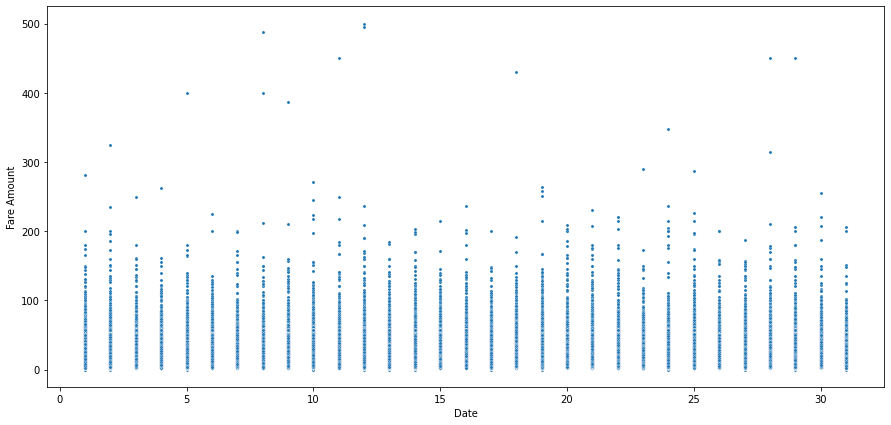

In [24]:
# Get the median fare for each month
month_price = train.groupby('month', as_index=False)['fare_amount'].median()

# Plot the median fare amount each month in the year
plt.figure(figsize=(12, 8))
months = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
sns.lineplot(data=month_price, x="month", y="fare_amount", marker="o")
plt.xlabel('Month')
plt.ylabel('Median fare amount')
plt.xticks(range(1, 13), months)
plt.title('Fare amount based on month of the year')
plt.show()

# How many trips are there each month?
plt.figure(figsize=(12, 8))
sns.countplot(data=train, x="month", color=(89/255, 117/255, 164/255, 1))
plt.xlabel("Month")
plt.ylabel("Observations")
plt.xticks(range(0, 12), months)
plt.show()

# How does the day of the month affect the price?
plt.figure(figsize=(15, 7))
sns.scatterplot(data=train, x="dayofmonth", y="fare_amount", s=10)
plt.xlabel('Date')
plt.ylabel('Fare Amount')
plt.show()

These plots are similar to our previous ones where we investigated the weeks of the year, but instead now we are looking at a different level of abstraction. The highest median fare amount occurs in December, and then a significant drop occurs to the lowest median fare amount in January. July and August also see a large dip in the median fare. When we look at our next plot of the number of trips, we can see the least amount of trips occur in July and August.

Other than these small variations there isn't anything significant to point out one month being far busier than any other.

We will now move to the highest level of abstraction that we have - the year feature.

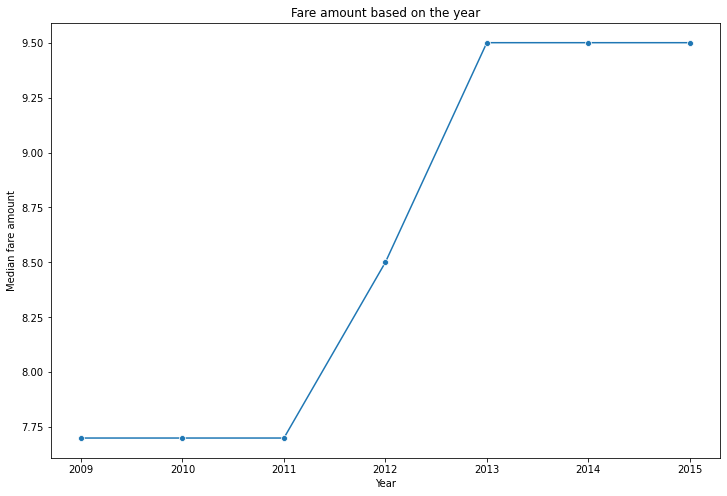

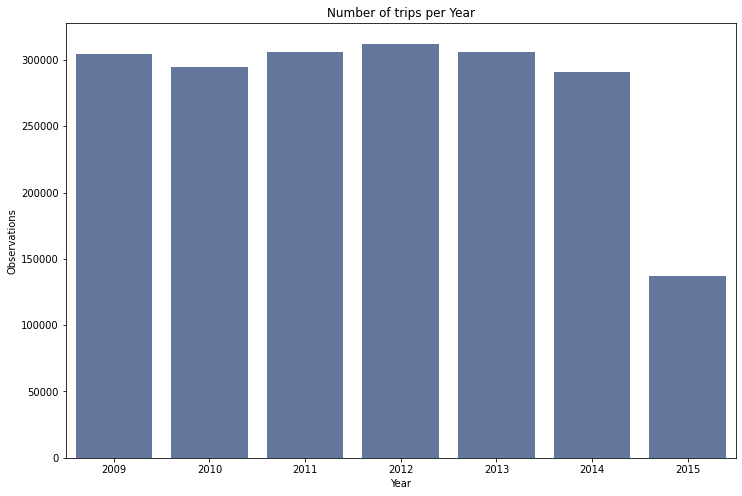

In [25]:
# Again we find the median fare price, but this time for each year
year_price = train.groupby('year', as_index=False)['fare_amount'].median()

# Now plot the median fare price for each year
plt.figure(figsize=(12, 8))
sns.lineplot(data=year_price, x="year", y="fare_amount", marker="o")
plt.xlabel('Year')
plt.ylabel('Median fare amount')
plt.title('Fare amount based on the year')
plt.show()

# Now plot the number of trips taken each year in our data
plt.figure(figsize=(12, 8))
sns.countplot(data=train, x="year", color=(89/255, 117/255, 164/255, 1))
plt.xlabel("Year")
plt.ylabel("Observations")
plt.title("Number of trips per Year")
plt.show()

It's interesting to see that the median fare sees no change in 2009, 2010, and 2011, but in 2012 we see a relatively sharp increase of \\$0.75 in the median fare, and in 2013 we see an increase of \\$1.00. The median fare then remains the same through 2013, 2014, and 2015.

The number of trips per year doesn't provide much insight into this, as it remains relatively steady with only mild fluctiations in the number of trips per year. The drop in 2015 is not important as we previously mentioned that this dataset simply doesn't contain data for the entirety of 2015.

This is our visualisation complete. It's always important to note that this is just a basic overview of each feature - you could go far further into depth with these, especially with the maps of NYC above. I would encourage any learners to take advantage of the ability to create interactive maps using Bokeh and other packages which can help visualise the trips in the state in an even better way.

## Part 2 - Model and Predictions

Now that we've done our preliminary data cleaning and feature selection, let's look at creating multiple models that will allow us to predict the fare amount on our test data for the competition.

The first thing that I always like to do is look at the columns in the train and test data. We've added a number of new features to our data so it's important to verify one last time that all the columns are as we expect before we begin to create a model.

In [26]:
# Take a look at our columns before we pass anything into our model to make sure we have the correct structure
print('Train columns:', train.columns.tolist())
print('\nTest columns:', test.columns.tolist())

# Remove the geometry column added for creating the plots earlier on the train data
train = train.drop("geometry", axis=1)

# Select only numeric features to use for our model training and predictions
# Note no key or pickup_datetime here
features = [
'pickup_longitude',
'pickup_latitude',
'dropoff_longitude',
'dropoff_latitude',
'distance_km',
'passenger_count',
'hour',
'dayofweek',
'dayofmonth',
'week',
'month',
'year',
'pickup_jfk_distance',
'dropof_jfk_distance',
'pickup_ewr_distance',
'dropof_ewr_distance',
'pickup_lga_distance',
'dropof_lga_distance']

Train columns: ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'geometry', 'hour', 'dayofweek', 'dayofmonth', 'week', 'month', 'year', 'distance_km', 'pickup_jfk_distance', 'dropof_jfk_distance', 'pickup_ewr_distance', 'dropof_ewr_distance', 'pickup_lga_distance', 'dropof_lga_distance']

Test columns: ['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'dayofweek', 'dayofmonth', 'week', 'month', 'year', 'distance_km', 'pickup_jfk_distance', 'dropof_jfk_distance', 'pickup_ewr_distance', 'dropof_ewr_distance', 'pickup_lga_distance', 'dropof_lga_distance']


We can see above that all the columns are correct. Note the absence of the fare amount column in the test data, as this is what we are trying to predict. Other than that, the datasets have the same columns. We've also defined the features we want to use in our model, ignoring the key and the fare amount in the train data.

For this notebook I'm only going to show one approach, using a package called Optuna.

Optuna is a package that will allow us to tune the hyperparameters of an XGBoost model by providing a set of hyperparameters to iterate through. It's efficient and far faster than other methods such as GridSearchCV which I haven't demonstrated here.

The first thing we do is define our objective function, specifying our train data and our train target. We then use train_test_split to split our train data into multiple sets, and then we define our hyperparameter grid, just as we would with any other hyperparameter searching package.

We then create an XGB Regression model which we will use to run through our hyperparameter grid.

In [27]:
# A list of hyperparameters available for tuning can be found at https://xgboost.readthedocs.io/en/latest/parameter.html

def objective(trial, data=train[features], target=train.fare_amount):
    
    x_train, x_test, y_train, y_test = train_test_split(train[features], train.fare_amount, test_size=0.2, random_state=1)
    
    param = {
        'tree_method':'gpu_hist',  # Use GPU acceleration
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6, 0.7, 0.8, 1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [4000, 5000, 6000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
        ),
        'random_state': 1,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    
    model = xgb.XGBRegressor(**param)  
    
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    predictions = model.predict(x_test)
    
    rmse = mean_squared_error(y_test, predictions, squared=False)
    
    return rmse

Now we create an Optuna study with 20 trials. We also generate some visualisations which will appear in the local notebook environment. To have these plots display in the browser instead (if running on a local jupyter kernel), add renderer="browser" in the show method.

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Plot the optimisation history, showing the scores from all the trials
optuna.visualization.plot_optimization_history(study).show()

# Create a parallel coordinate plot
optuna.visualization.plot_parallel_coordinate(study).show()

# Plot the feature importance of each individual hyperparameter being tuned
optuna.visualization.plot_param_importances(study).show()

# Finally, plot the best parameters
study.best_params

# Now store the best hyperparameters that we obtained, as well as maintaining the random state and gpu acceleration for the final model
best_params = study.best_params
best_params['tree_method'] = 'gpu_hist'
best_params['random_state'] = 1

[I 2021-08-26 02:42:45,870] A new study created in memory with name: no-name-25e8baba-b850-425e-a75d-b3f1ca2d4fd8
[I 2021-08-26 02:46:17,630] Trial 0 finished with value: 3.616190268316312 and parameters: {'lambda': 0.0030169906729727207, 'alpha': 0.06783700552659463, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.018, 'n_estimators': 4000, 'max_depth': 10, 'min_child_weight': 265}. Best is trial 0 with value: 3.616190268316312.
[I 2021-08-26 02:49:29,200] Trial 1 finished with value: 3.5990031287846276 and parameters: {'lambda': 6.966412438871289, 'alpha': 0.06635380833939163, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 6000, 'max_depth': 14, 'min_child_weight': 10}. Best is trial 1 with value: 3.5990031287846276.


Now that we have obtained the best hyperparameters from our grid, we create a final XGB Regressor with these parameters and then fit the new model to our train data once again. We then make predictions on the provided test data and export these predictions as a CSV file.

In [ ]:
clf = xgb.XGBRegressor(**(best_params))

clf.fit(train[features], train.fare_amount)

predictions = clf.predict(test[features])

# Confirm that our predictions are the same shape as the test data
print(predictions.shape)
print(test.shape)

holdout = pd.DataFrame({'key': test['key'], 'fare_amount': predictions})
holdout.to_csv('predictions.csv', index=False)

One final visualisation we generate is the feature importances for each feature in the model - note that this is different from the Optuna feature importance which is for the importance of each hyperparameter, not each feature in the model.

In [ ]:
# Create a horizontal bar chart of the model feature importances, note that we have 18 features
feature_importances = pd.Series(clf.feature_importances_, index=train[features].columns)
feature_importances.nlargest(20).plot(kind='barh')
plt.show()

This simple submission using one model and hyperparameter tuning using Optuna gives a top 10% ranking in the competition. To further improve I would encourage the reader to think about the following topics:
* Data cleaning thoroughly, i.e. dropping outliers in a more accurate way than simply just chopping at a given latitude and longitude
* Further feature selection, either through dropping features that aren't significant and creating further new features that may help model performance
* Multiple models (LGBM/RF are good starters), varied hyperparameter grids, and model ensembling

That's everything for this notebook. I hope you've been able to learn something and if you have any feedback feel free to get in touch.